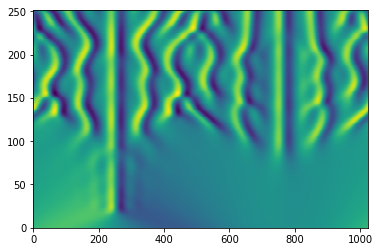

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt

# Kuramoto-Sivashinsky equation (from Trefethen)
# u_t = -u*u_x - u_xx - u_xxxx,  periodic BCs 

N = 1024;
x = 32*np.pi*np.arange(1,N+1)/N;
u = np.cos(x/16)*(1+np.sin(x/16)); 
v = np.fft.fft(u);

#Spatial grid and initial condition:
h = 0.025;
k = np.concatenate([np.arange(0,N/2),[0],np.arange(-N/2+1,0)])/16;
L = k**2 - k**4;
E = np.exp(h*L); E2 = np.exp(h*L/2);
M = 16;
r = np.exp(1j*np.pi*(np.arange(1,M+1)-.5)/M)
LR = h*np.tile(L,(M,1)).T + np.tile(r,(N,1))
Q = h*np.real(np.mean( (np.exp(LR/2)-1)/LR, axis=1)); 
f1 = h*np.real(np.mean( (-4-LR+np.exp(LR)*(4-3*LR+LR**2))/LR**3, axis=1)); 
f2 = h*np.real(np.mean( (2+LR+np.exp(LR)*(-2+LR))/LR**3, axis=1));
f3 = h*np.real(np.mean( (-4-3*LR-LR**2+np.exp(LR)*(4-LR))/LR**3, axis=1));

# Main time-stepping loop:
uu = u; tt = 0;
tmax = 100; nmax = round(tmax/h); nplt = np.floor((tmax/250)/h); g = -0.5j*k;
for n in range(1,nmax+1):
    t = n*h;
    Nv = g*np.fft.fft(np.real(np.fft.ifft(v))**2);
    a = E2*v + Q*Nv;
    Na = g*np.fft.fft(np.real(np.fft.ifft(a))**2);
    b = E2*v + Q*Na;
    Nb = g*np.fft.fft(np.real(np.fft.ifft(b))**2);
    c = E2*a + Q*(2*Nb-Nv);
    Nc = g*np.fft.fft(np.real(np.fft.ifft(c))**2);
    v = E*v + Nv*f1 + 2*(Na+Nb)*f2 + Nc*f3; 
    if np.mod(n,nplt)==0:
        u = np.real(np.fft.ifft(v));
        uu = np.vstack([uu,u]); tt = np.append(tt,t);

# Plot results:
plt.figure()
plt.pcolormesh(uu)
plt.show()

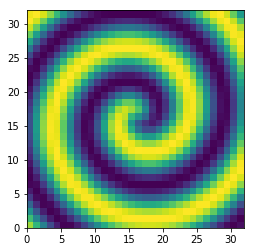

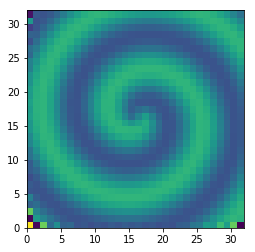

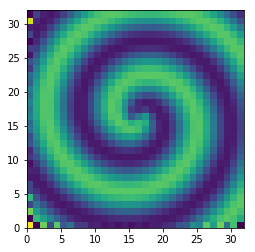

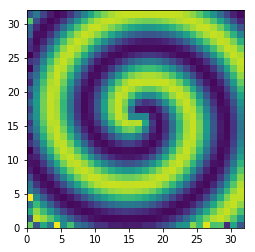

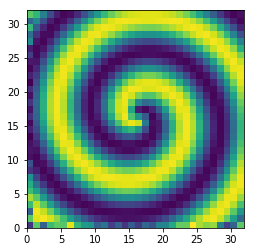

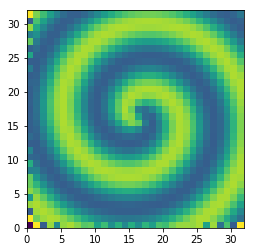

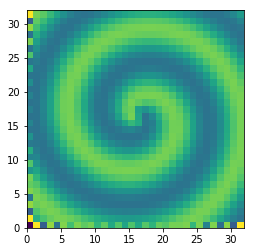

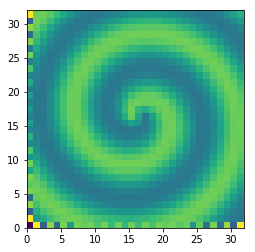

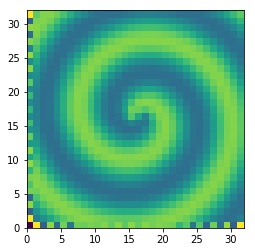

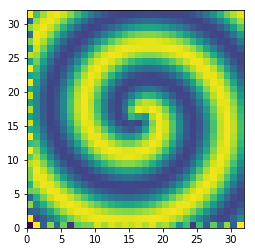

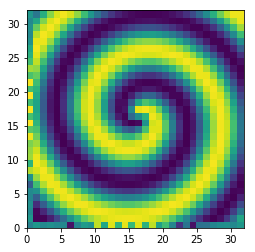

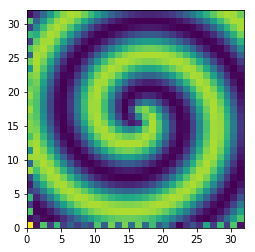

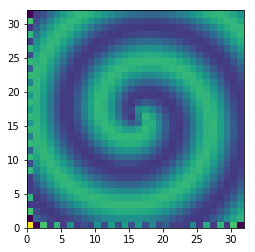

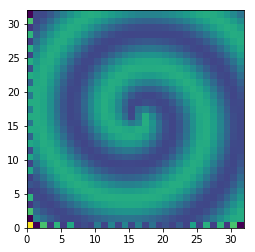

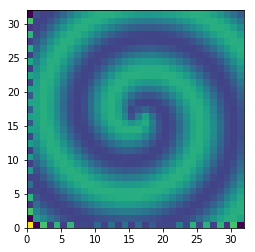

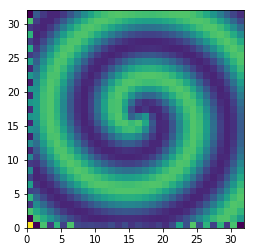

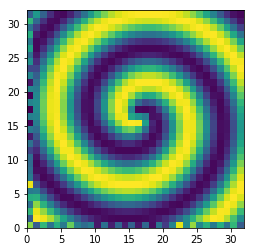

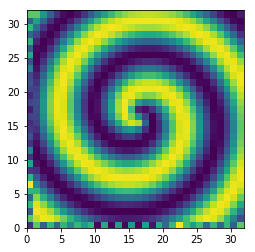

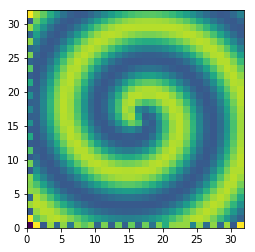

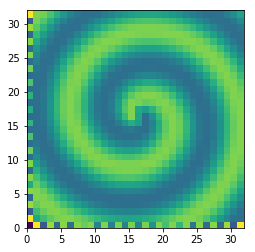

In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt

def reaction_diffusion_rhs(t,uvt,K22,d1,d2,beta,n,N):
    # Calculate u and v terms
    ut=np.reshape(uvt[:N],(n,n));
    vt=np.reshape(uvt[N:],(n,n));
    u=np.real(np.fft.ifft2(ut)); v=np.real(np.fft.ifft2(vt));
    
    # Reaction Terms
    u3=u**3; v3=v**3; u2v=(u**2)*v; uv2=u*(v**2);
    utrhs=np.reshape(np.fft.fft2(u-u3-uv2+beta*u2v+beta*v3),(N,1));
    vtrhs=np.reshape(np.fft.fft2(v-u2v-v3-beta*u3-beta*uv2),(N,1));
    
    return np.concatenate([-d1*K22*uvt[:N]+utrhs, -d2*K22*uvt[N:]+vtrhs])[:,0]

# lambda-omega reaction-diffusion system
#  u_t = lam(A) u - ome(A) v + d1*(u_xx + u_yy) = 0
#  v_t = ome(A) u + lam(A) v + d2*(v_xx + v_yy) = 0
#
#  A^2 = u^2 + v^2 and
#  lam(A) = 1 - A^2
#  ome(A) = -beta*A^2


t=np.linspace(0,10,201);
d1=0.1; d2=0.1; beta=1.0;
L=20; n=32; N=n*n;
x2=np.linspace(-L/2,L/2,n+1); x=x2[0:n]; y=x;
kx=(2*np.pi/L)*np.concatenate([np.arange(0,n/2), np.arange(-n/2,0)]); ky=kx;

# INITIAL CONDITIONS

[X,Y]=np.meshgrid(x,y);
[KX,KY]=np.meshgrid(kx,ky);
K2=KX**2+KY**2; K22=np.reshape(K2,(N,1));

m=1; # number of spirals

u = np.zeros((len(x),len(y),len(t)));
v = np.zeros((len(x),len(y),len(t)));

u[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.cos(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));
v[:,:,0]=np.tanh(np.sqrt(X**2+Y**2))*np.sin(m*np.angle(X+1j*Y)-(np.sqrt(X**2+Y**2)));

# REACTION-DIFFUSION
uvt=np.concatenate([np.reshape(np.fft.fft2(u[:,:,0]).T,(N,1)), np.reshape(np.fft.fft2(v[:,:,0]).T,(N,1))]);
#uvsol=integrate.complex_ode(reaction_diffusion_rhs,uvt[:,0],t,args=(K22,d1,d2,beta,n,N));
sol=integrate.solve_ivp(lambda t,u: reaction_diffusion_rhs(t,u,K22,d1,d2,beta,n,N),[0,10],uvt[:,0],t_eval=t,method='RK45');
uvsol = sol.y

#%%
for j in range(len(t)-1):
    ut=np.reshape(uvsol[:N,j+1],(n,n));
    vt=np.reshape(uvsol[N:,j+1],(n,n));
    u[:,:,j+1]=np.real(np.fft.ifft2(ut));
    v[:,:,j+1]=np.real(np.fft.ifft2(vt));

np.savez('reaction_diffusion_big.npz',t=t,x=x,y=y,u=u,v=v)

for j in np.arange(0,200,10):
    plt.figure()
    plt.pcolormesh(v[:,:,j])
    plt.axis('image')